Author: Moonsu Kang
Date: 12/06/2016

In [7]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import random 
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.contrib.layers import flatten

### Data Exploration

In [6]:
training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))
print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Test Set:       {} samples".format(len(X_test)))


Image Shape: (32, 32, 3)

Training Set:   39209 samples
Test Set:       12630 samples


In [15]:
len(X_train)/(len(X_train)+len(X_test))

0.7563610409151411

28


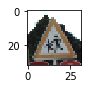

In [13]:
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

### Preprocess Data

In [14]:
# shuffle dataset

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [19]:
len(X_train)/(len(X_train)+len(X_test)+len(X_validation))

0.6050849746329984

In [20]:
len(X_validation)/(len(X_train)+len(X_test)+len(X_validation))

0.1512760662821428

In [73]:
len(X_test)/(len(X_train)+len(X_test)+len(X_validation))

0.24363895908485889

### CNN architecture

In [21]:
EPOCHS = 20
BATCH_SIZE = 128
keep_prob = tf.placeholder(tf.float32)

In [28]:
def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    #Input = 32x32x1. Output = 32x32x1. 
    conv0_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 3, 3), mean = mu, stddev = sigma))
    conv0_b = tf.Variable(tf.zeros(3))
    conv0   = tf.nn.conv2d(x, conv0_W, strides=[1, 1, 1, 1], padding='VALID') + conv0_b
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(conv0, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    # Activation 1
    conv1 = tf.nn.relu(conv1)
      
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
   
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    # Activation 2
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b 
    # Activation 3
    fc1    = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1,keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    # Activation 4
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Features and Labels

In [ ]:
# variables
x = tf.placeholder(tf.float32, (None, 32, 32, 3)) # 3 for rgb
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

### Training Pipeline

In [35]:
# learning rate
rate = 0.0008 

# loss function, optimizer selection
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation

In [36]:
# evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Training

In [38]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5}) #,
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.698

EPOCH 2 ...
Validation Accuracy = 0.864

EPOCH 3 ...
Validation Accuracy = 0.921

EPOCH 4 ...
Validation Accuracy = 0.932

EPOCH 5 ...
Validation Accuracy = 0.947

EPOCH 6 ...
Validation Accuracy = 0.955

EPOCH 7 ...
Validation Accuracy = 0.961

EPOCH 8 ...
Validation Accuracy = 0.970

EPOCH 9 ...
Validation Accuracy = 0.968

EPOCH 10 ...
Validation Accuracy = 0.973

EPOCH 11 ...
Validation Accuracy = 0.976

EPOCH 12 ...
Validation Accuracy = 0.973

EPOCH 13 ...
Validation Accuracy = 0.978

EPOCH 14 ...
Validation Accuracy = 0.977

EPOCH 15 ...
Validation Accuracy = 0.981

EPOCH 16 ...
Validation Accuracy = 0.981

EPOCH 17 ...
Validation Accuracy = 0.985

EPOCH 18 ...
Validation Accuracy = 0.984

Model saved


### Test

In [39]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
 
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.933


### Visualize

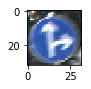

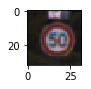

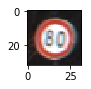

In [69]:
def new_image_process(a,b):
    index = random.randint(0, len(a))
    image = a[index].squeeze()
    ans = b[index]
    plt.figure(figsize=(1,1))
    plt.imshow(image)
    return image,ans

img1,ans1 = new_image_process(X_test,y_test)
img2,ans2 = new_image_process(X_test,y_test)
img3,ans3 = new_image_process(X_test,y_test)

In [98]:
images=np.array([img1,img2,img3],dtype=np.float32)
ans = np.array([ans1,ans2,ans3])
ans

array([36,  2,  5], dtype=uint8)

In [72]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    
    get_new_prediction = tf.argmax(logits, 1)
    new_predictions = sess.run(get_new_prediction, feed_dict={x: images,keep_prob: 1})
print (new_predictions) 

INFO:tensorflow:Restoring parameters from ./lenet
[36  2  5]


In [92]:
import pandas as pd
signs = pd.read_csv('signnames.csv')

signnames =[]
for a in new_predictions:
    signnames.append(signs['SignName'][signs['ClassId']==a].values[0])

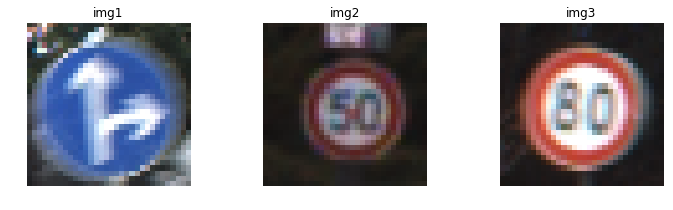

Correct classficiations are:        [36  2  5] 
Predicted classficiations are:      [36  2  5] 
Sign name of classes are:           ['Go straight or right', 'Speed limit (50km/h)', 'Speed limit (80km/h)']


In [97]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.imshow(img1)
plt.title('img1')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(img2)
plt.title('img2')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(img3)
plt.title('img3')
plt.axis('off')
plt.show()

print("Correct classficiations are:        {} ".format(ans))
print("Predicted classficiations are:      {} ".format(new_predictions)) 
print("Sign name of classes are:           {}".format(signnames))

#### We find that the traffic sign classifications from model is equivalent with what they should be!